# Binary Prediction of Income using US Census Data


#### Background Information

The United States Census Bureau leads the country’s Federal Statistical System; its primary
responsibility is to collect demographic and economic data about America to help inform
strategic initiatives. Every ten years, the census is conducted to collect and organize information
regarding the US population to effectively allocate billions of dollars of funding to various
endeavors (e.g., the building and maintenance of hospitals, schools, fire departments,
transportation infrastructure, etc.). Additionally, the collection of census information helps to
examine the demographic characteristics of subpopulations across the country.


##### Use Case
The tasks is to identify characteristics that are associated with a person making more or less than $50,000 per year.

In [1]:
#Packages
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.tree import plot_tree
plt.style.use('ggplot')

##### Data

A sample dataset from the US Census archive containing detailed but 
anonymized information for ~300,000 individuals. 

In [2]:
#Import Learning Dataset
df_learn = pd.read_csv('census_income_learn.csv', header=None)
# Add headers
df_learn.columns = ['age', 'class_of_worker', 'industry_numcd', 'occupation_numcd', 'education', 'wage_per_hour', 'enroll_edu_inst_lst_wk', 
                   'marital_stat', 'industry_cd', 'occupation_cd', 'race', 'hispanic_origin', 'sex', 'memb_labor_union', 'reason_unemployment',
                   'full_part_employment_stat', 'capital_gains', 'capital_losses','stock_dividends', 'tax_filer_stat', 
                   'region_prev_resid', 'state_prev_resid', 'household_stat', 'household_summ', 
                   'weight_ignore_in_model', 'mig_cd_in_msa', 'mig_cd_in_reg', 'mig_cd_move_reg', 'live_house_1_yr_ago',
                   'mig_prev_res_in_sunbelt','num_persons_worked_for_employer','fam_memb_under_18','cob_father',
                   'cob_mother','cob_self','citizenship','own_business_or_self_employed',
                   'veterans_admin','veterans_benefits', 'weeks_worked_in_year','year', 'target'
                  ]
df_learn.head()

,age,class_of_worker,industry_numcd,occupation_numcd,education,wage_per_hour,enroll_edu_inst_lst_wk,marital_stat,industry_cd,occupation_cd,...,cob_father,cob_mother,cob_self,citizenship,own_business_or_self_employed,veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [3]:
#Import Testing Dataset
df_test = pd.read_csv('census_income_test.csv', header=None)
# Add headers
df_test.columns = ['age', 'class_of_worker', 'industry_numcd', 'occupation_numcd', 'education', 'wage_per_hour', 'enroll_edu_inst_lst_wk', 
                   'marital_stat', 'industry_cd', 'occupation_cd', 'race', 'hispanic_origin', 'sex', 'memb_labor_union', 'reason_unemployment',
                   'full_part_employment_stat', 'capital_gains', 'capital_losses','stock_dividends', 'tax_filer_stat', 
                   'region_prev_resid', 'state_prev_resid', 'household_stat', 'household_summ', 
                   'weight_ignore_in_model', 'mig_cd_in_msa', 'mig_cd_in_reg', 'mig_cd_move_reg', 'live_house_1_yr_ago',
                   'mig_prev_res_in_sunbelt','num_persons_worked_for_employer','fam_memb_under_18','cob_father',
                   'cob_mother','cob_self','citizenship','own_business_or_self_employed',
                   'veterans_admin','veterans_benefits', 'weeks_worked_in_year','year', 'target'
                  ]
df_test.head()

,age,class_of_worker,industry_numcd,occupation_numcd,education,wage_per_hour,enroll_edu_inst_lst_wk,marital_stat,industry_cd,occupation_cd,...,cob_father,cob_mother,cob_self,citizenship,own_business_or_self_employed,veterans_admin,veterans_benefits,weeks_worked_in_year,year,target
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


#### Exploratory Data Analysis 
Numerical and/or graphical representations of the data that 
may help inform insights and/or tactics for answering the research question of interest.

###### Training Dataset Exploration

Training/Learning dataset has 199,523 rows and 42 columns. No missing data but several duplicates. Target variables is as expected but needs to be recoded. Categorical variables will need to be recoded and "?" removed. 

In [4]:
# check for missing values - learn
df_learn.isnull().sum()

age                                0
class_of_worker                    0
industry_numcd                     0
occupation_numcd                   0
education                          0
wage_per_hour                      0
enroll_edu_inst_lst_wk             0
marital_stat                       0
industry_cd                        0
occupation_cd                      0
race                               0
hispanic_origin                    0
sex                                0
memb_labor_union                   0
reason_unemployment                0
full_part_employment_stat          0
capital_gains                      0
capital_losses                     0
stock_dividends                    0
tax_filer_stat                     0
region_prev_resid                  0
state_prev_resid                   0
household_stat                     0
household_summ                     0
weight_ignore_in_model             0
mig_cd_in_msa                      0
mig_cd_in_reg                      0
m

In [5]:
print('Training/Learning Dataset Description:')
df_learn.describe()

Training/Learning Dataset Description:


,age,industry_numcd,occupation_numcd,wage_per_hour,capital_gains,capital_losses,stock_dividends,weight_ignore_in_model,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [6]:
print('Shape of df_learn:', df_learn.shape)

Shape of df_learn: (199523, 42)


In [7]:
df_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   age                              199523 non-null  int64  
 1   class_of_worker                  199523 non-null  object 
 2   industry_numcd                   199523 non-null  int64  
 3   occupation_numcd                 199523 non-null  int64  
 4   education                        199523 non-null  object 
 5   wage_per_hour                    199523 non-null  int64  
 6   enroll_edu_inst_lst_wk           199523 non-null  object 
 7   marital_stat                     199523 non-null  object 
 8   industry_cd                      199523 non-null  object 
 9   occupation_cd                    199523 non-null  object 
 10  race                             199523 non-null  object 
 11  hispanic_origin                  199523 non-null  object 
 12  se

In [8]:
#crosstab of occupation vars

# print('Crosstab of Industry_numcd and Industry_cd')
# crosstab_learn_industry = pd.crosstab(df_learn['industry_numcd'], df_learn['industry_cd'])
# print(crosstab_learn_industry)

# print('Crosstab of Occupation_numcd and occupation_cd')
# crosstab_learn_occ = pd.crosstab(df_learn['occupation_numcd'], df_learn['occupation_cd'])
# print(crosstab_learn_occ)

# checking to see if these variables are exactly the same. Neither industry nor occupation are exactly the same, but definitly correlated, 
# as their numeric code. Since I don't have insight into what these numeric codes mean exactly, I will keep both in the model.

###### Testing Dataset Exploration

Testing dataset has 99,762 rows and 42 columns. No missing data but several duplicates. Target variables is as expected but needs to be recoded. Categorical variables will need to be recoded and "?" removed. 

In [9]:
# check for missing values - test
df_test.isnull().sum() 

age                                0
class_of_worker                    0
industry_numcd                     0
occupation_numcd                   0
education                          0
wage_per_hour                      0
enroll_edu_inst_lst_wk             0
marital_stat                       0
industry_cd                        0
occupation_cd                      0
race                               0
hispanic_origin                    0
sex                                0
memb_labor_union                   0
reason_unemployment                0
full_part_employment_stat          0
capital_gains                      0
capital_losses                     0
stock_dividends                    0
tax_filer_stat                     0
region_prev_resid                  0
state_prev_resid                   0
household_stat                     0
household_summ                     0
weight_ignore_in_model             0
mig_cd_in_msa                      0
mig_cd_in_reg                      0
m

In [10]:
print('Shape of df_test:', df_test.shape)

Shape of df_test: (99762, 42)


In [11]:
print('Test Dataset Description:')
df_test.describe()

Test Dataset Description:


,age,industry_numcd,occupation_numcd,wage_per_hour,capital_gains,capital_losses,stock_dividends,weight_ignore_in_model,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000
mean,34.628596,15.332812,11.331118,54.461268,425.788577,35.919458,192.494727,1739.542838,1.956156,0.178505,1.519827,23.185331,94.500652
std,22.333449,18.026709,14.459589,270.202643,4616.795578,265.525252,1841.728492,994.900902,2.364331,0.558316,0.848229,24.389184,0.500002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.260000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1058.050000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1615.395000,1.000000,0.000000,2.000000,8.000000,95.000000
75%,50.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2187.277500,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9900.000000,99999.000000,4608.000000,99999.000000,16258.200000,6.000000,2.000000,2.000000,52.000000,95.000000


##### Target Variable \- Income Under or Over \\$50,000/year. From the histogram below, we can see that this datais not well balancedn. Therefore,we need to sample the data before running the model to not give them model prefernce in the binary prediction. .

[Text(0.5, 1.0, 'The Distribution of Target Variable')]

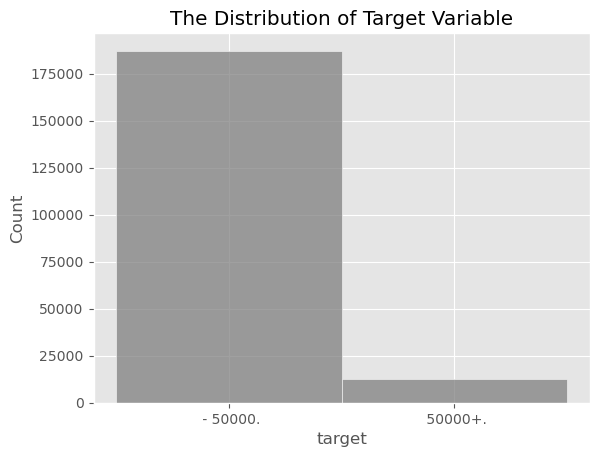

In [12]:
sns.histplot(df_learn['target'],color='gray').set(title='The Distribution of Target Variable')

In [13]:
#Find Distinct Values in the Target Column to assist in balancing - needed to know exact entries for target
def get_distinct_values(variable):
    """Returns a set of distinct values in the given variable."""
    return set(variable)

distinct_values_learn = get_distinct_values(df_learn['target'])
print('Values in the Target - Learning Dataset', distinct_values_learn)

distinct_values_test = get_distinct_values(df_test['target'])
print('Values in the Target - Testing Dataset', distinct_values_test)

Values in the Target - Learning Dataset {' - 50000.', ' 50000+.'}
Values in the Target - Testing Dataset {' - 50000.', ' 50000+.'}


#### Data Preparation
Data cleaning, preprocessing, feature engineering, etc., that may aid 
in improving data clarity & model generation.

In [14]:
#reformat Target variable 
df_learn['target_cd'] = df_learn['target'].apply(lambda x: 0 if x == ' - 50000.' else 1)
df_test['target_cd'] = df_test['target'].apply(lambda x: 0 if x == ' - 50000.' else 1)

#cross tab of new variables
crosstab_learn = pd.crosstab(df_learn['target'], df_learn['target_cd'])
print(crosstab_learn)

crosstab_test = pd.crosstab(df_test['target'], df_test['target_cd'])
print(crosstab_test)

target_cd       0      1
target                  
 - 50000.  187141      0
 50000+.        0  12382
target_cd      0     1
target                
 - 50000.  93576     0
 50000+.       0  6186


In [15]:
#recode variables

#take out "?"
df_learn = df_learn[df_learn['mig_cd_in_msa'].str.contains("\?") == False]
df_test = df_test[df_test['mig_cd_in_msa'].str.contains("\?") == False]
df_learn = df_learn[df_learn['state_prev_resid'].str.contains("\?") == False]
df_test = df_test[df_test['state_prev_resid'].str.contains("\?") == False]
df_learn = df_learn[df_learn['cob_father'].str.contains("\?") == False]
df_test = df_test[df_test['cob_father'].str.contains("\?") == False]
df_learn = df_learn[df_learn['cob_mother'].str.contains("\?") == False]
df_test = df_test[df_test['cob_mother'].str.contains("\?") == False]
df_learn = df_learn[df_learn['cob_self'].str.contains("\?") == False]
df_test = df_test[df_test['cob_self'].str.contains("\?") == False]

#one hot encoding of categorical variables
df_learn_oh = pd.get_dummies(df_learn, columns=['class_of_worker', 'education', 'enroll_edu_inst_lst_wk', 
                   'marital_stat', 'industry_cd', 'occupation_cd', 'race', 'hispanic_origin', 'sex', 'memb_labor_union', 'reason_unemployment',
                   'full_part_employment_stat',  'tax_filer_stat', 
                   'region_prev_resid', 'state_prev_resid', 'household_stat', 'household_summ', 
                   'mig_cd_in_msa', 'mig_cd_in_reg', 'mig_cd_move_reg', 'live_house_1_yr_ago',
                   'mig_prev_res_in_sunbelt','fam_memb_under_18','cob_father',
                   'cob_mother','cob_self','citizenship',
                   'veterans_admin'])
df_test_oh = pd.get_dummies(df_test, columns=['class_of_worker', 'education', 'enroll_edu_inst_lst_wk', 
                   'marital_stat', 'industry_cd', 'occupation_cd', 'race', 'hispanic_origin', 'sex', 'memb_labor_union', 'reason_unemployment',
                   'full_part_employment_stat',  'tax_filer_stat', 
                   'region_prev_resid', 'state_prev_resid', 'household_stat', 'household_summ', 
                   'mig_cd_in_msa', 'mig_cd_in_reg', 'mig_cd_move_reg', 'live_house_1_yr_ago',
                   'mig_prev_res_in_sunbelt','fam_memb_under_18','cob_father',
                   'cob_mother','cob_self','citizenship',
                   'veterans_admin'])

#add vars to test because one hot coding made them not equal
df_test_oh['household_stat_ Grandchild <18 ever marr not in subfamily'] = False
df_test_oh['household_stat_ Other Rel <18 ever marr RP of subfamily'] = False
df_learn_oh['household_stat_ Other Rel <18 ever marr not in subfamily'] = False
df_learn_oh['cob_self_ Holand-Netherlands'] = False
num_variables_test = len(df_test_oh.columns)
print('Number of Varibales in New Test Set:', num_variables_test) 

num_variables_learn = len(df_learn_oh.columns)
print('Number of Varibales in New Learn Set:', num_variables_learn) 

# Find columns in df1 not in df2
df1_not_df2 = df_learn_oh.columns[~df_learn_oh.columns.isin(df_test_oh.columns)]
print("Columns in df1 but not in df2:", df1_not_df2)

# Find columns in df2 not in df1
df2_not_df1 = df_test_oh.columns[~df_test_oh.columns.isin(df_learn_oh.columns)]
print("Columns in df2 but not in df1:", df2_not_df1)


Number of Varibales in New Test Set: 391
Number of Varibales in New Learn Set: 391
Columns in df1 but not in df2: Index([], dtype='object')
Columns in df2 but not in df1: Index([], dtype='object')


In [16]:
#dedup
df_learn_unique = df_learn_oh.drop_duplicates()
df_learn_unique.info()

#crosstab after dedup
crosstab_learn = pd.crosstab(df_learn_unique['target'], df_learn_unique['target_cd'])
print(crosstab_learn)


df_test_unique = df_test_oh.drop_duplicates()
df_test_unique.info()

#make sure the object is the original target
#print(df_test_unique.select_dtypes(include='object').columns.tolist())

<class 'pandas.core.frame.DataFrame'>
Index: 93590 entries, 1 to 199519
Columns: 391 entries, age to cob_self_ Holand-Netherlands
dtypes: bool(376), float64(1), int64(13), object(1)
memory usage: 45.0+ MB
target_cd      0     1
target                
 - 50000.  88111     0
 50000+.       0  5479
<class 'pandas.core.frame.DataFrame'>
Index: 46987 entries, 3 to 99761
Columns: 391 entries, age to household_stat_ Other Rel <18 ever marr RP of subfamily
dtypes: bool(376), float64(1), int64(13), object(1)
memory usage: 22.6+ MB


In [17]:
#scratch work to get headers
# headers = df_learn_unique.columns.tolist()
# print(headers)

In [18]:
#sample to balance target vars
X_learn=df_learn_unique[['age', 'industry_numcd', 'occupation_numcd', 'wage_per_hour', 'capital_gains', 'capital_losses', 'stock_dividends', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'year', 'class_of_worker_ Federal government', 'class_of_worker_ Local government', 'class_of_worker_ Never worked', 'class_of_worker_ Not in universe', 'class_of_worker_ Private', 'class_of_worker_ Self-employed-incorporated', 'class_of_worker_ Self-employed-not incorporated', 'class_of_worker_ State government', 'class_of_worker_ Without pay', 'education_ 10th grade', 'education_ 11th grade', 'education_ 12th grade no diploma', 'education_ 1st 2nd 3rd or 4th grade', 'education_ 5th or 6th grade', 'education_ 7th and 8th grade', 'education_ 9th grade', 'education_ Associates degree-academic program', 'education_ Associates degree-occup /vocational', 'education_ Bachelors degree(BA AB BS)', 'education_ Children', 'education_ Doctorate degree(PhD EdD)', 'education_ High school graduate', 'education_ Less than 1st grade', 'education_ Masters degree(MA MS MEng MEd MSW MBA)', 'education_ Prof school degree (MD DDS DVM LLB JD)', 'education_ Some college but no degree', 'enroll_edu_inst_lst_wk_ College or university', 'enroll_edu_inst_lst_wk_ High school', 'enroll_edu_inst_lst_wk_ Not in universe', 'marital_stat_ Divorced', 'marital_stat_ Married-A F spouse present', 'marital_stat_ Married-civilian spouse present', 'marital_stat_ Married-spouse absent', 'marital_stat_ Never married', 'marital_stat_ Separated', 'marital_stat_ Widowed', 'industry_cd_ Agriculture', 'industry_cd_ Armed Forces', 'industry_cd_ Business and repair services', 'industry_cd_ Communications', 'industry_cd_ Construction', 'industry_cd_ Education', 'industry_cd_ Entertainment', 'industry_cd_ Finance insurance and real estate', 'industry_cd_ Forestry and fisheries', 'industry_cd_ Hospital services', 'industry_cd_ Manufacturing-durable goods', 'industry_cd_ Manufacturing-nondurable goods', 'industry_cd_ Medical except hospital', 'industry_cd_ Mining', 'industry_cd_ Not in universe or children', 'industry_cd_ Other professional services', 'industry_cd_ Personal services except private HH', 'industry_cd_ Private household services', 'industry_cd_ Public administration', 'industry_cd_ Retail trade', 'industry_cd_ Social services', 'industry_cd_ Transportation', 'industry_cd_ Utilities and sanitary services', 'industry_cd_ Wholesale trade', 'occupation_cd_ Adm support including clerical', 'occupation_cd_ Armed Forces', 'occupation_cd_ Executive admin and managerial', 'occupation_cd_ Farming forestry and fishing', 'occupation_cd_ Handlers equip cleaners etc ', 'occupation_cd_ Machine operators assmblrs & inspctrs', 'occupation_cd_ Not in universe', 'occupation_cd_ Other service', 'occupation_cd_ Precision production craft & repair', 'occupation_cd_ Private household services', 'occupation_cd_ Professional specialty', 'occupation_cd_ Protective services', 'occupation_cd_ Sales', 'occupation_cd_ Technicians and related support', 'occupation_cd_ Transportation and material moving', 'race_ Amer Indian Aleut or Eskimo', 'race_ Asian or Pacific Islander', 'race_ Black', 'race_ Other', 'race_ White', 'hispanic_origin_ All other', 'hispanic_origin_ Central or South American', 'hispanic_origin_ Chicano', 'hispanic_origin_ Cuban', 'hispanic_origin_ Do not know', 'hispanic_origin_ Mexican (Mexicano)', 'hispanic_origin_ Mexican-American', 'hispanic_origin_ NA', 'hispanic_origin_ Other Spanish', 'hispanic_origin_ Puerto Rican', 'sex_ Female', 'sex_ Male', 'memb_labor_union_ No', 'memb_labor_union_ Not in universe', 'memb_labor_union_ Yes', 'reason_unemployment_ Job leaver', 'reason_unemployment_ Job loser - on layoff', 'reason_unemployment_ New entrant', 'reason_unemployment_ Not in universe', 'reason_unemployment_ Other job loser', 'reason_unemployment_ Re-entrant', 'full_part_employment_stat_ Children or Armed Forces', 'tax_filer_stat_ Head of household', 'tax_filer_stat_ Joint both 65+', 'tax_filer_stat_ Joint both under 65', 'tax_filer_stat_ Joint one under 65 & one 65+', 'tax_filer_stat_ Nonfiler', 'tax_filer_stat_ Single', 'region_prev_resid_ Abroad', 'region_prev_resid_ Midwest', 'region_prev_resid_ Northeast', 'region_prev_resid_ Not in universe', 'region_prev_resid_ South', 'region_prev_resid_ West', 'state_prev_resid_ Abroad', 'state_prev_resid_ Alabama', 'state_prev_resid_ Alaska', 'state_prev_resid_ Arizona', 'state_prev_resid_ Arkansas', 'state_prev_resid_ California', 'state_prev_resid_ Colorado', 'state_prev_resid_ Connecticut', 'state_prev_resid_ Delaware', 'state_prev_resid_ District of Columbia', 'state_prev_resid_ Florida', 'state_prev_resid_ Georgia', 'state_prev_resid_ Idaho', 'state_prev_resid_ Illinois', 'state_prev_resid_ Indiana', 'state_prev_resid_ Iowa', 'state_prev_resid_ Kansas', 'state_prev_resid_ Kentucky', 'state_prev_resid_ Louisiana', 'state_prev_resid_ Maine', 'state_prev_resid_ Maryland', 'state_prev_resid_ Massachusetts', 'state_prev_resid_ Michigan', 'state_prev_resid_ Minnesota', 'state_prev_resid_ Mississippi', 'state_prev_resid_ Missouri', 'state_prev_resid_ Montana', 'state_prev_resid_ Nebraska', 'state_prev_resid_ Nevada', 'state_prev_resid_ New Hampshire', 'state_prev_resid_ New Jersey', 'state_prev_resid_ New Mexico', 'state_prev_resid_ New York', 'state_prev_resid_ North Carolina', 'state_prev_resid_ North Dakota', 'state_prev_resid_ Not in universe', 'state_prev_resid_ Ohio', 'state_prev_resid_ Oklahoma', 'state_prev_resid_ Oregon', 'state_prev_resid_ Pennsylvania', 'state_prev_resid_ South Carolina', 'state_prev_resid_ South Dakota', 'state_prev_resid_ Tennessee', 'state_prev_resid_ Texas', 'state_prev_resid_ Utah', 'state_prev_resid_ Vermont', 'state_prev_resid_ Virginia', 'state_prev_resid_ West Virginia', 'state_prev_resid_ Wisconsin', 'state_prev_resid_ Wyoming', 'household_stat_ Child 18+ ever marr Not in a subfamily', 'household_stat_ Child 18+ ever marr RP of subfamily', 'household_stat_ Child 18+ never marr Not in a subfamily', 'household_stat_ Child 18+ never marr RP of subfamily', 'household_stat_ Child 18+ spouse of subfamily RP', 'household_stat_ Child <18 ever marr RP of subfamily', 'household_stat_ Child <18 ever marr not in subfamily', 'household_stat_ Child <18 never marr RP of subfamily', 'household_stat_ Child <18 never marr not in subfamily', 'household_stat_ Child <18 spouse of subfamily RP', 'household_stat_ Child under 18 of RP of unrel subfamily', 'household_stat_ Grandchild 18+ ever marr RP of subfamily', 'household_stat_ Grandchild 18+ ever marr not in subfamily', 'household_stat_ Grandchild 18+ never marr RP of subfamily', 'household_stat_ Grandchild 18+ never marr not in subfamily', 'household_stat_ Grandchild 18+ spouse of subfamily RP', 'household_stat_ Grandchild <18 ever marr not in subfamily', 'household_stat_ Grandchild <18 never marr RP of subfamily', 'household_stat_ Grandchild <18 never marr child of subfamily RP', 'household_stat_ Grandchild <18 never marr not in subfamily', 'household_stat_ Householder', 'household_stat_ In group quarters', 'household_stat_ Nonfamily householder', 'household_stat_ Other Rel 18+ ever marr RP of subfamily', 'household_stat_ Other Rel 18+ ever marr not in subfamily', 'household_stat_ Other Rel 18+ never marr RP of subfamily', 'household_stat_ Other Rel 18+ never marr not in subfamily', 'household_stat_ Other Rel 18+ spouse of subfamily RP', 'household_stat_ Other Rel <18 ever marr RP of subfamily', 'household_stat_ Other Rel <18 never marr child of subfamily RP', 'household_stat_ Other Rel <18 never marr not in subfamily', 'household_stat_ Other Rel <18 never married RP of subfamily', 'household_stat_ Other Rel <18 spouse of subfamily RP', 'household_stat_ RP of unrelated subfamily', 'household_stat_ Secondary individual', 'household_stat_ Spouse of RP of unrelated subfamily', 'household_stat_ Spouse of householder', 'household_summ_ Child 18 or older', 'household_summ_ Child under 18 ever married', 'household_summ_ Child under 18 never married', 'household_summ_ Group Quarters- Secondary individual', 'household_summ_ Householder', 'household_summ_ Nonrelative of householder', 'household_summ_ Other relative of householder', 'household_summ_ Spouse of householder', 'mig_cd_in_msa_ Abroad to MSA', 'mig_cd_in_msa_ Abroad to nonMSA', 'mig_cd_in_msa_ MSA to MSA', 'mig_cd_in_msa_ MSA to nonMSA', 'mig_cd_in_msa_ NonMSA to MSA', 'mig_cd_in_msa_ NonMSA to nonMSA', 'mig_cd_in_msa_ Nonmover', 'mig_cd_in_msa_ Not identifiable', 'mig_cd_in_msa_ Not in universe', 'mig_cd_in_reg_ Abroad', 'mig_cd_in_reg_ Different county same state', 'mig_cd_in_reg_ Different division same region', 'mig_cd_in_reg_ Different region', 'mig_cd_in_reg_ Different state same division', 'mig_cd_in_reg_ Nonmover', 'mig_cd_in_reg_ Not in universe', 'mig_cd_in_reg_ Same county', 'mig_cd_move_reg_ Abroad', 'mig_cd_move_reg_ Different county same state', 'mig_cd_move_reg_ Different state in Midwest', 'mig_cd_move_reg_ Different state in Northeast', 'mig_cd_move_reg_ Different state in South', 'mig_cd_move_reg_ Different state in West', 'mig_cd_move_reg_ Nonmover', 'mig_cd_move_reg_ Not in universe', 'mig_cd_move_reg_ Same county', 'live_house_1_yr_ago_ No', 'live_house_1_yr_ago_ Not in universe under 1 year old', 'live_house_1_yr_ago_ Yes', 'mig_prev_res_in_sunbelt_ No', 'mig_prev_res_in_sunbelt_ Not in universe', 'mig_prev_res_in_sunbelt_ Yes', 'fam_memb_under_18_ Both parents present', 'fam_memb_under_18_ Father only present', 'fam_memb_under_18_ Mother only present', 'fam_memb_under_18_ Neither parent present', 'fam_memb_under_18_ Not in universe', 'cob_father_ Cambodia', 'cob_father_ Canada', 'cob_father_ China', 'cob_father_ Columbia', 'cob_father_ Cuba', 'cob_father_ Dominican-Republic', 'cob_father_ Ecuador', 'cob_father_ El-Salvador', 'cob_father_ England', 'cob_father_ France', 'cob_father_ Germany', 'cob_father_ Greece', 'cob_father_ Guatemala', 'cob_father_ Haiti', 'cob_father_ Honduras', 'cob_father_ Hong Kong', 'cob_father_ Hungary', 'cob_father_ India', 'cob_father_ Iran', 'cob_father_ Ireland', 'cob_father_ Italy', 'cob_father_ Jamaica', 'cob_father_ Japan', 'cob_father_ Laos', 'cob_father_ Mexico', 'cob_father_ Nicaragua', 'cob_father_ Outlying-U S (Guam USVI etc)', 'cob_father_ Peru', 'cob_father_ Philippines', 'cob_father_ Poland', 'cob_father_ Portugal', 'cob_father_ Puerto-Rico', 'cob_father_ Scotland', 'cob_father_ South Korea', 'cob_father_ Taiwan', 'cob_father_ Thailand', 'cob_father_ Trinadad&Tobago', 'cob_father_ United-States', 'cob_father_ Vietnam', 'cob_father_ Yugoslavia', 'cob_mother_ Cambodia', 'cob_mother_ Canada', 'cob_mother_ China', 'cob_mother_ Columbia', 'cob_mother_ Cuba', 'cob_mother_ Dominican-Republic', 'cob_mother_ Ecuador', 'cob_mother_ El-Salvador', 'cob_mother_ England', 'cob_mother_ France', 'cob_mother_ Germany', 'cob_mother_ Greece', 'cob_mother_ Guatemala', 'cob_mother_ Haiti', 'cob_mother_ Honduras', 'cob_mother_ Hong Kong', 'cob_mother_ Hungary', 'cob_mother_ India', 'cob_mother_ Iran', 'cob_mother_ Ireland', 'cob_mother_ Italy', 'cob_mother_ Jamaica', 'cob_mother_ Japan', 'cob_mother_ Laos', 'cob_mother_ Mexico', 'cob_mother_ Nicaragua', 'cob_mother_ Outlying-U S (Guam USVI etc)', 'cob_mother_ Peru', 'cob_mother_ Philippines', 'cob_mother_ Poland', 'cob_mother_ Portugal', 'cob_mother_ Puerto-Rico', 'cob_mother_ Scotland', 'cob_mother_ South Korea', 'cob_mother_ Taiwan', 'cob_mother_ Thailand', 'cob_mother_ Trinadad&Tobago', 'cob_mother_ United-States', 'cob_mother_ Vietnam', 'cob_mother_ Yugoslavia', 'cob_self_ Cambodia', 'cob_self_ Canada', 'cob_self_ China', 'cob_self_ Columbia', 'cob_self_ Cuba', 'cob_self_ Dominican-Republic', 'cob_self_ Ecuador', 'cob_self_ El-Salvador', 'cob_self_ England', 'cob_self_ France', 'cob_self_ Germany', 'cob_self_ Greece', 'cob_self_ Guatemala', 'cob_self_ Haiti', 'cob_self_ Honduras', 'cob_self_ Hong Kong', 'cob_self_ Hungary', 'cob_self_ India', 'cob_self_ Iran', 'cob_self_ Ireland', 'cob_self_ Italy', 'cob_self_ Jamaica', 'cob_self_ Japan', 'cob_self_ Laos', 'cob_self_ Mexico', 'cob_self_ Nicaragua', 'cob_self_ Outlying-U S (Guam USVI etc)', 'cob_self_ Peru', 'cob_self_ Philippines', 'cob_self_ Poland', 'cob_self_ Portugal', 'cob_self_ Puerto-Rico', 'cob_self_ Scotland', 'cob_self_ South Korea', 'cob_self_ Taiwan', 'cob_self_ Thailand', 'cob_self_ Trinadad&Tobago', 'cob_self_ United-States', 'cob_self_ Vietnam', 'cob_self_ Yugoslavia', 'citizenship_ Foreign born- Not a citizen of U S ', 'citizenship_ Foreign born- U S citizen by naturalization', 'citizenship_ Native- Born abroad of American Parent(s)', 'citizenship_ Native- Born in Puerto Rico or U S Outlying', 'citizenship_ Native- Born in the United States', 'veterans_admin_ No', 'veterans_admin_ Not in universe', 'veterans_admin_ Yes', 'household_stat_ Other Rel <18 ever marr not in subfamily', 'cob_self_ Holand-Netherlands'
                        ]] 
y_learn=df_learn_unique['target_cd']
#balance data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_learn, y_learn)

#count to make sure balanced
print(y_resampled.value_counts())

target_cd
0    5479
1    5479
Name: count, dtype: int64


#### Data Modeling
The building of a few competing models to predict the target variable.

Decision Tree and Random Forest Models were built to make a binary prediction for income at the threshold of \\$50,000. 

In [19]:
#test dateframe
X_test=df_test_unique[['age', 'industry_numcd', 'occupation_numcd', 'wage_per_hour', 'capital_gains', 'capital_losses', 'stock_dividends', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'year', 'class_of_worker_ Federal government', 'class_of_worker_ Local government', 'class_of_worker_ Never worked', 'class_of_worker_ Not in universe', 'class_of_worker_ Private', 'class_of_worker_ Self-employed-incorporated', 'class_of_worker_ Self-employed-not incorporated', 'class_of_worker_ State government', 'class_of_worker_ Without pay', 'education_ 10th grade', 'education_ 11th grade', 'education_ 12th grade no diploma', 'education_ 1st 2nd 3rd or 4th grade', 'education_ 5th or 6th grade', 'education_ 7th and 8th grade', 'education_ 9th grade', 'education_ Associates degree-academic program', 'education_ Associates degree-occup /vocational', 'education_ Bachelors degree(BA AB BS)', 'education_ Children', 'education_ Doctorate degree(PhD EdD)', 'education_ High school graduate', 'education_ Less than 1st grade', 'education_ Masters degree(MA MS MEng MEd MSW MBA)', 'education_ Prof school degree (MD DDS DVM LLB JD)', 'education_ Some college but no degree', 'enroll_edu_inst_lst_wk_ College or university', 'enroll_edu_inst_lst_wk_ High school', 'enroll_edu_inst_lst_wk_ Not in universe', 'marital_stat_ Divorced', 'marital_stat_ Married-A F spouse present', 'marital_stat_ Married-civilian spouse present', 'marital_stat_ Married-spouse absent', 'marital_stat_ Never married', 'marital_stat_ Separated', 'marital_stat_ Widowed', 'industry_cd_ Agriculture', 'industry_cd_ Armed Forces', 'industry_cd_ Business and repair services', 'industry_cd_ Communications', 'industry_cd_ Construction', 'industry_cd_ Education', 'industry_cd_ Entertainment', 'industry_cd_ Finance insurance and real estate', 'industry_cd_ Forestry and fisheries', 'industry_cd_ Hospital services', 'industry_cd_ Manufacturing-durable goods', 'industry_cd_ Manufacturing-nondurable goods', 'industry_cd_ Medical except hospital', 'industry_cd_ Mining', 'industry_cd_ Not in universe or children', 'industry_cd_ Other professional services', 'industry_cd_ Personal services except private HH', 'industry_cd_ Private household services', 'industry_cd_ Public administration', 'industry_cd_ Retail trade', 'industry_cd_ Social services', 'industry_cd_ Transportation', 'industry_cd_ Utilities and sanitary services', 'industry_cd_ Wholesale trade', 'occupation_cd_ Adm support including clerical', 'occupation_cd_ Armed Forces', 'occupation_cd_ Executive admin and managerial', 'occupation_cd_ Farming forestry and fishing', 'occupation_cd_ Handlers equip cleaners etc ', 'occupation_cd_ Machine operators assmblrs & inspctrs', 'occupation_cd_ Not in universe', 'occupation_cd_ Other service', 'occupation_cd_ Precision production craft & repair', 'occupation_cd_ Private household services', 'occupation_cd_ Professional specialty', 'occupation_cd_ Protective services', 'occupation_cd_ Sales', 'occupation_cd_ Technicians and related support', 'occupation_cd_ Transportation and material moving', 'race_ Amer Indian Aleut or Eskimo', 'race_ Asian or Pacific Islander', 'race_ Black', 'race_ Other', 'race_ White', 'hispanic_origin_ All other', 'hispanic_origin_ Central or South American', 'hispanic_origin_ Chicano', 'hispanic_origin_ Cuban', 'hispanic_origin_ Do not know', 'hispanic_origin_ Mexican (Mexicano)', 'hispanic_origin_ Mexican-American', 'hispanic_origin_ NA', 'hispanic_origin_ Other Spanish', 'hispanic_origin_ Puerto Rican', 'sex_ Female', 'sex_ Male', 'memb_labor_union_ No', 'memb_labor_union_ Not in universe', 'memb_labor_union_ Yes', 'reason_unemployment_ Job leaver', 'reason_unemployment_ Job loser - on layoff', 'reason_unemployment_ New entrant', 'reason_unemployment_ Not in universe', 'reason_unemployment_ Other job loser', 'reason_unemployment_ Re-entrant', 'full_part_employment_stat_ Children or Armed Forces', 'tax_filer_stat_ Head of household', 'tax_filer_stat_ Joint both 65+', 'tax_filer_stat_ Joint both under 65', 'tax_filer_stat_ Joint one under 65 & one 65+', 'tax_filer_stat_ Nonfiler', 'tax_filer_stat_ Single', 'region_prev_resid_ Abroad', 'region_prev_resid_ Midwest', 'region_prev_resid_ Northeast', 'region_prev_resid_ Not in universe', 'region_prev_resid_ South', 'region_prev_resid_ West', 'state_prev_resid_ Abroad', 'state_prev_resid_ Alabama', 'state_prev_resid_ Alaska', 'state_prev_resid_ Arizona', 'state_prev_resid_ Arkansas', 'state_prev_resid_ California', 'state_prev_resid_ Colorado', 'state_prev_resid_ Connecticut', 'state_prev_resid_ Delaware', 'state_prev_resid_ District of Columbia', 'state_prev_resid_ Florida', 'state_prev_resid_ Georgia', 'state_prev_resid_ Idaho', 'state_prev_resid_ Illinois', 'state_prev_resid_ Indiana', 'state_prev_resid_ Iowa', 'state_prev_resid_ Kansas', 'state_prev_resid_ Kentucky', 'state_prev_resid_ Louisiana', 'state_prev_resid_ Maine', 'state_prev_resid_ Maryland', 'state_prev_resid_ Massachusetts', 'state_prev_resid_ Michigan', 'state_prev_resid_ Minnesota', 'state_prev_resid_ Mississippi', 'state_prev_resid_ Missouri', 'state_prev_resid_ Montana', 'state_prev_resid_ Nebraska', 'state_prev_resid_ Nevada', 'state_prev_resid_ New Hampshire', 'state_prev_resid_ New Jersey', 'state_prev_resid_ New Mexico', 'state_prev_resid_ New York', 'state_prev_resid_ North Carolina', 'state_prev_resid_ North Dakota', 'state_prev_resid_ Not in universe', 'state_prev_resid_ Ohio', 'state_prev_resid_ Oklahoma', 'state_prev_resid_ Oregon', 'state_prev_resid_ Pennsylvania', 'state_prev_resid_ South Carolina', 'state_prev_resid_ South Dakota', 'state_prev_resid_ Tennessee', 'state_prev_resid_ Texas', 'state_prev_resid_ Utah', 'state_prev_resid_ Vermont', 'state_prev_resid_ Virginia', 'state_prev_resid_ West Virginia', 'state_prev_resid_ Wisconsin', 'state_prev_resid_ Wyoming', 'household_stat_ Child 18+ ever marr Not in a subfamily', 'household_stat_ Child 18+ ever marr RP of subfamily', 'household_stat_ Child 18+ never marr Not in a subfamily', 'household_stat_ Child 18+ never marr RP of subfamily', 'household_stat_ Child 18+ spouse of subfamily RP', 'household_stat_ Child <18 ever marr RP of subfamily', 'household_stat_ Child <18 ever marr not in subfamily', 'household_stat_ Child <18 never marr RP of subfamily', 'household_stat_ Child <18 never marr not in subfamily', 'household_stat_ Child <18 spouse of subfamily RP', 'household_stat_ Child under 18 of RP of unrel subfamily', 'household_stat_ Grandchild 18+ ever marr RP of subfamily', 'household_stat_ Grandchild 18+ ever marr not in subfamily', 'household_stat_ Grandchild 18+ never marr RP of subfamily', 'household_stat_ Grandchild 18+ never marr not in subfamily', 'household_stat_ Grandchild 18+ spouse of subfamily RP', 'household_stat_ Grandchild <18 ever marr not in subfamily', 'household_stat_ Grandchild <18 never marr RP of subfamily', 'household_stat_ Grandchild <18 never marr child of subfamily RP', 'household_stat_ Grandchild <18 never marr not in subfamily', 'household_stat_ Householder', 'household_stat_ In group quarters', 'household_stat_ Nonfamily householder', 'household_stat_ Other Rel 18+ ever marr RP of subfamily', 'household_stat_ Other Rel 18+ ever marr not in subfamily', 'household_stat_ Other Rel 18+ never marr RP of subfamily', 'household_stat_ Other Rel 18+ never marr not in subfamily', 'household_stat_ Other Rel 18+ spouse of subfamily RP', 'household_stat_ Other Rel <18 ever marr RP of subfamily', 'household_stat_ Other Rel <18 never marr child of subfamily RP', 'household_stat_ Other Rel <18 never marr not in subfamily', 'household_stat_ Other Rel <18 never married RP of subfamily', 'household_stat_ Other Rel <18 spouse of subfamily RP', 'household_stat_ RP of unrelated subfamily', 'household_stat_ Secondary individual', 'household_stat_ Spouse of RP of unrelated subfamily', 'household_stat_ Spouse of householder', 'household_summ_ Child 18 or older', 'household_summ_ Child under 18 ever married', 'household_summ_ Child under 18 never married', 'household_summ_ Group Quarters- Secondary individual', 'household_summ_ Householder', 'household_summ_ Nonrelative of householder', 'household_summ_ Other relative of householder', 'household_summ_ Spouse of householder', 'mig_cd_in_msa_ Abroad to MSA', 'mig_cd_in_msa_ Abroad to nonMSA', 'mig_cd_in_msa_ MSA to MSA', 'mig_cd_in_msa_ MSA to nonMSA', 'mig_cd_in_msa_ NonMSA to MSA', 'mig_cd_in_msa_ NonMSA to nonMSA', 'mig_cd_in_msa_ Nonmover', 'mig_cd_in_msa_ Not identifiable', 'mig_cd_in_msa_ Not in universe', 'mig_cd_in_reg_ Abroad', 'mig_cd_in_reg_ Different county same state', 'mig_cd_in_reg_ Different division same region', 'mig_cd_in_reg_ Different region', 'mig_cd_in_reg_ Different state same division', 'mig_cd_in_reg_ Nonmover', 'mig_cd_in_reg_ Not in universe', 'mig_cd_in_reg_ Same county', 'mig_cd_move_reg_ Abroad', 'mig_cd_move_reg_ Different county same state', 'mig_cd_move_reg_ Different state in Midwest', 'mig_cd_move_reg_ Different state in Northeast', 'mig_cd_move_reg_ Different state in South', 'mig_cd_move_reg_ Different state in West', 'mig_cd_move_reg_ Nonmover', 'mig_cd_move_reg_ Not in universe', 'mig_cd_move_reg_ Same county', 'live_house_1_yr_ago_ No', 'live_house_1_yr_ago_ Not in universe under 1 year old', 'live_house_1_yr_ago_ Yes', 'mig_prev_res_in_sunbelt_ No', 'mig_prev_res_in_sunbelt_ Not in universe', 'mig_prev_res_in_sunbelt_ Yes', 'fam_memb_under_18_ Both parents present', 'fam_memb_under_18_ Father only present', 'fam_memb_under_18_ Mother only present', 'fam_memb_under_18_ Neither parent present', 'fam_memb_under_18_ Not in universe', 'cob_father_ Cambodia', 'cob_father_ Canada', 'cob_father_ China', 'cob_father_ Columbia', 'cob_father_ Cuba', 'cob_father_ Dominican-Republic', 'cob_father_ Ecuador', 'cob_father_ El-Salvador', 'cob_father_ England', 'cob_father_ France', 'cob_father_ Germany', 'cob_father_ Greece', 'cob_father_ Guatemala', 'cob_father_ Haiti', 'cob_father_ Honduras', 'cob_father_ Hong Kong', 'cob_father_ Hungary', 'cob_father_ India', 'cob_father_ Iran', 'cob_father_ Ireland', 'cob_father_ Italy', 'cob_father_ Jamaica', 'cob_father_ Japan', 'cob_father_ Laos', 'cob_father_ Mexico', 'cob_father_ Nicaragua', 'cob_father_ Outlying-U S (Guam USVI etc)', 'cob_father_ Peru', 'cob_father_ Philippines', 'cob_father_ Poland', 'cob_father_ Portugal', 'cob_father_ Puerto-Rico', 'cob_father_ Scotland', 'cob_father_ South Korea', 'cob_father_ Taiwan', 'cob_father_ Thailand', 'cob_father_ Trinadad&Tobago', 'cob_father_ United-States', 'cob_father_ Vietnam', 'cob_father_ Yugoslavia', 'cob_mother_ Cambodia', 'cob_mother_ Canada', 'cob_mother_ China', 'cob_mother_ Columbia', 'cob_mother_ Cuba', 'cob_mother_ Dominican-Republic', 'cob_mother_ Ecuador', 'cob_mother_ El-Salvador', 'cob_mother_ England', 'cob_mother_ France', 'cob_mother_ Germany', 'cob_mother_ Greece', 'cob_mother_ Guatemala', 'cob_mother_ Haiti', 'cob_mother_ Honduras', 'cob_mother_ Hong Kong', 'cob_mother_ Hungary', 'cob_mother_ India', 'cob_mother_ Iran', 'cob_mother_ Ireland', 'cob_mother_ Italy', 'cob_mother_ Jamaica', 'cob_mother_ Japan', 'cob_mother_ Laos', 'cob_mother_ Mexico', 'cob_mother_ Nicaragua', 'cob_mother_ Outlying-U S (Guam USVI etc)', 'cob_mother_ Peru', 'cob_mother_ Philippines', 'cob_mother_ Poland', 'cob_mother_ Portugal', 'cob_mother_ Puerto-Rico', 'cob_mother_ Scotland', 'cob_mother_ South Korea', 'cob_mother_ Taiwan', 'cob_mother_ Thailand', 'cob_mother_ Trinadad&Tobago', 'cob_mother_ United-States', 'cob_mother_ Vietnam', 'cob_mother_ Yugoslavia', 'cob_self_ Cambodia', 'cob_self_ Canada', 'cob_self_ China', 'cob_self_ Columbia', 'cob_self_ Cuba', 'cob_self_ Dominican-Republic', 'cob_self_ Ecuador', 'cob_self_ El-Salvador', 'cob_self_ England', 'cob_self_ France', 'cob_self_ Germany', 'cob_self_ Greece', 'cob_self_ Guatemala', 'cob_self_ Haiti', 'cob_self_ Honduras', 'cob_self_ Hong Kong', 'cob_self_ Hungary', 'cob_self_ India', 'cob_self_ Iran', 'cob_self_ Ireland', 'cob_self_ Italy', 'cob_self_ Jamaica', 'cob_self_ Japan', 'cob_self_ Laos', 'cob_self_ Mexico', 'cob_self_ Nicaragua', 'cob_self_ Outlying-U S (Guam USVI etc)', 'cob_self_ Peru', 'cob_self_ Philippines', 'cob_self_ Poland', 'cob_self_ Portugal', 'cob_self_ Puerto-Rico', 'cob_self_ Scotland', 'cob_self_ South Korea', 'cob_self_ Taiwan', 'cob_self_ Thailand', 'cob_self_ Trinadad&Tobago', 'cob_self_ United-States', 'cob_self_ Vietnam', 'cob_self_ Yugoslavia', 'citizenship_ Foreign born- Not a citizen of U S ', 'citizenship_ Foreign born- U S citizen by naturalization', 'citizenship_ Native- Born abroad of American Parent(s)', 'citizenship_ Native- Born in Puerto Rico or U S Outlying', 'citizenship_ Native- Born in the United States', 'veterans_admin_ No', 'veterans_admin_ Not in universe', 'veterans_admin_ Yes', 'household_stat_ Other Rel <18 ever marr not in subfamily', 'cob_self_ Holand-Netherlands'
                     ]] 
y_test=df_test_unique['target_cd']

#what is the breakdown of the test target?
print('Breakdown of Test Target')
print(y_test.value_counts())

# Decision Tree Model
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42, ccp_alpha=0.0001)
# Performing training
dt_gini.fit(X_resampled, y_resampled)
#predict 
y_pred = dt_gini.predict(X_test)

#what is the breakdown of the predicated target?
df = pd.DataFrame()
df['y_pred'] = y_pred
print('Breakdown of Prediction')
print(df.value_counts())

Breakdown of Test Target
target_cd
0    44304
1     2683
Name: count, dtype: int64
Breakdown of Prediction
y_pred
0         33256
1         13731
Name: count, dtype: int64


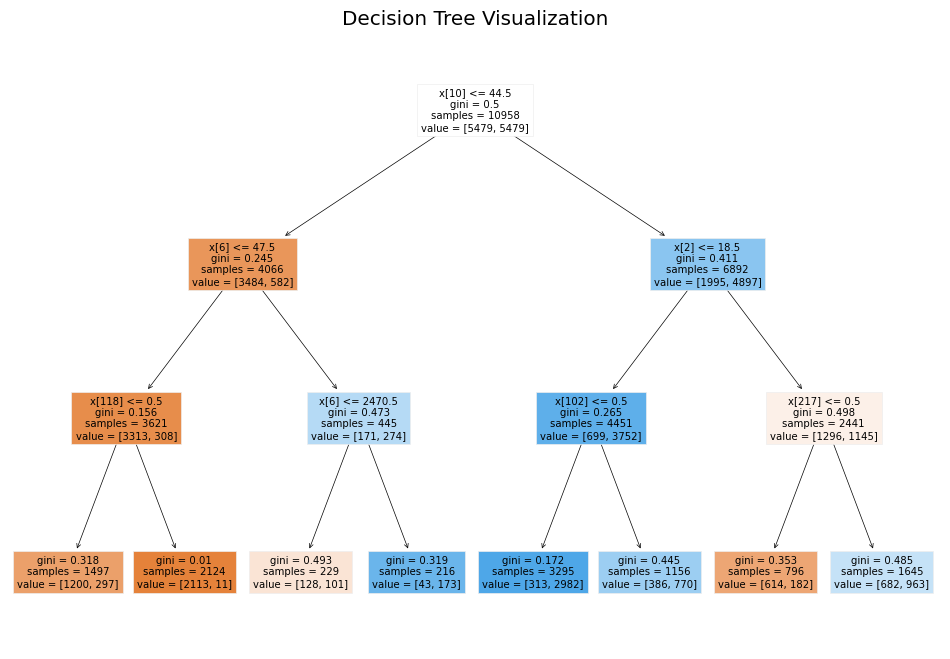

In [20]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_gini, filled=True)
plt.title('Decision Tree Visualization')
plt.show()

In [21]:
#Feature Importance for Decision Tree
importance = dt_gini.feature_importances_

#Visualize feature importances
# print('Feature Importance for Decision Tree Model:')
# for i, v in enumerate(importance):
#     print(f'Feature: {i}, Score: {v:.3f}')
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# Sort by importance and get the top 5
# Create a dataframe to store feature names and importances
feature_importances = pd.DataFrame({'feature': X_resampled.columns, 'importance': importance})
top_5_features = feature_importances.sort_values('importance', ascending=False).head(5)
print('Top 5 Feature for Decision Tree:')
print(top_5_features)

Top 5 Feature for Decision Tree:
                         feature  importance
10          weeks_worked_in_year    0.623908
2               occupation_numcd    0.167004
6                stock_dividends    0.095484
217  household_summ_ Householder    0.051743
102                  sex_ Female    0.037019


In [22]:
#get accuracy and metrics
print('Model accuracy score for Decision Tree: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
#tree.plot_tree(clf)

Model accuracy score for Decision Tree: 0.7517


In [23]:
#Confusion Matrix
print('Confusion Matrix Decision Tree: \n',  confusion_matrix(y_test, y_pred))

# Rows represent the true classes.
# Columns represent the predicted classes.
# The diagonal elements represent the correct predictions (True Positives and True Negatives).
# The off-diagonal elements represent the incorrect predictions (False Positives and False Negatives).

#Accuracy Report 
print('Classification Report Decision Tree: \n',classification_report(y_pred, y_test))

Confusion Matrix Decision Tree: 
 [[32947 11357]
 [  309  2374]]
Classification Report Decision Tree: 
               precision    recall  f1-score   support

           0       0.74      0.99      0.85     33256
           1       0.88      0.17      0.29     13731

    accuracy                           0.75     46987
   macro avg       0.81      0.58      0.57     46987
weighted avg       0.78      0.75      0.69     46987



Decision Tree AUC score: 0.8142439356409489


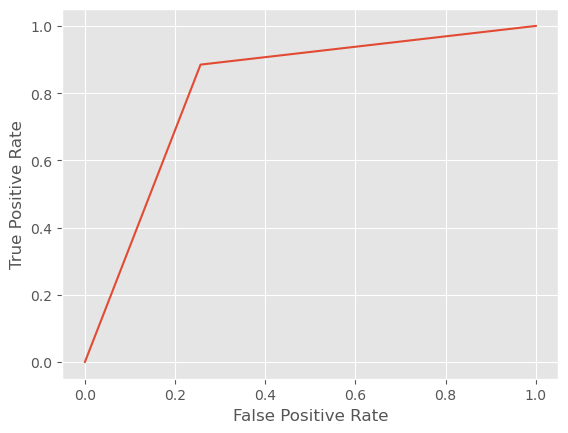

In [24]:
#The AUC-ROC curve, or Area Under the Receiver Operating Characteristic curve, is a graphical representation of the performance 
#of a binary classification model at various classification thresholds. It is commonly used in machine learning to assess the ability 
#of a model to distinguish between two classes.

#decision tree
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test, y_pred)
print(f'Decision Tree AUC score: {roc_auc_score(y_test, y_pred)}')

In [25]:
#Use Weight Column to Look at Accuracy of Decision Tree
#need to match index of predications  with index from test and multiply then do accuracy again to see if it is different
df_arr = pd.DataFrame({'y_pred': y_pred}, index=df_test_unique.index)
merged_df = pd.merge(df_test_unique, df_arr, left_index=True, right_index=True)
df_acc = merged_df[['weight_ignore_in_model', 'target_cd', 'y_pred']]

#multiple out results
#total sum of weight var
sum_weight_total=df_acc['weight_ignore_in_model'].sum()

df_acc2 = df_acc.copy()
df_acc2['weight_times_acc'] =df_acc['weight_ignore_in_model'] * df_acc.apply(lambda x: 1 if x['target_cd'] == x['y_pred']  else 0, axis=1)
print(df_acc2)

sum_weight=df_acc2['weight_times_acc'].sum()
weighted_accuracy_dt=sum_weight/sum_weight_total

print('Model weighted accuracy score for Decision Tree:')
print(weighted_accuracy_dt)

       weight_ignore_in_model  target_cd  y_pred  weight_times_acc
3                     1866.88          0       1              0.00
5                     2556.34          0       0           2556.34
6                     1723.61          0       0           1723.61
8                     1767.95          0       1              0.00
9                     1595.19          0       0           1595.19
...                       ...        ...     ...               ...
99746                 1102.46          0       0           1102.46
99750                 1107.49          0       0           1107.49
99751                 1164.53          0       1              0.00
99759                 2083.76          0       0           2083.76
99761                 1582.48          0       0           1582.48

[46987 rows x 4 columns]
Model weighted accuracy score for Decision Tree:
0.7526331520865316


In [26]:
#second model - Random Forest
rf = RandomForestClassifier(random_state=24, n_estimators =80, ccp_alpha=0.0001)
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)

In [27]:
#Feature Importance for Random Forest
importance = rf.feature_importances_

#Visualize feature importances
# print('Feature for Random Forest:')
# for i, v in enumerate(importance):
#     print(f'Feature: {i}, Score: {v:.3f}')
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# Sort by importance and get the top 5
# Create a dataframe to store feature names and importances
feature_importances = pd.DataFrame({'feature': X_resampled.columns, 'importance': importance})
top_5_features = feature_importances.sort_values('importance', ascending=False).head(5)
print('Top 5 Feature for Random Forest:')
print(top_5_features)

Top 5 Feature for Random Forest:
                 feature  importance
10  weeks_worked_in_year    0.067697
0                    age    0.060704
1         industry_numcd    0.059432
2       occupation_numcd    0.058441
6        stock_dividends    0.052288


In [28]:
#metrics
#get accuracy and metrics
print('Model accuracy score for Random Forest: {0:0.4f}'. format(accuracy_score(y_test, y_pred_rf)))
#tree.plot_tree(clf)

print('Confusion Matrix Random Forest: \n',  confusion_matrix(y_test, y_pred_rf))
print('Classification Report Random Forest: \n',classification_report(y_pred_rf, y_test))


#looking at Macro Avg - If there is a class which occurs less frequently but is equally important as the rest, 
#then macro-average is the preferred metric.

Model accuracy score for Random Forest: 0.8447
Confusion Matrix Random Forest: 
 [[37281  7023]
 [  276  2407]]
Classification Report Random Forest: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     37557
           1       0.90      0.26      0.40      9430

    accuracy                           0.84     46987
   macro avg       0.87      0.62      0.65     46987
weighted avg       0.85      0.84      0.81     46987



Random Forest AUC score: 0.8693058300345379


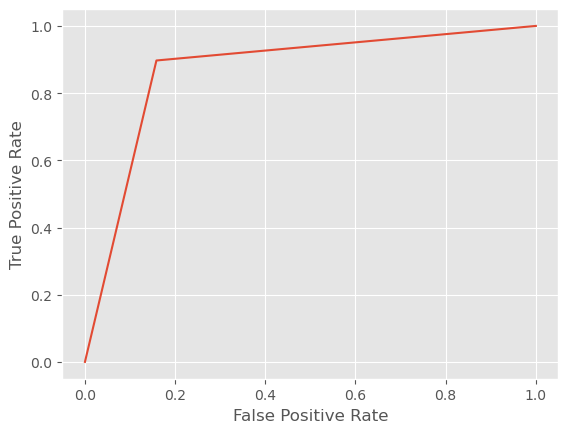

In [29]:
#The AUC-ROC curve, or Area Under the Receiver Operating Characteristic curve, is a graphical representation of the performance 
#of a binary classification model at various classification thresholds. It is commonly used in machine learning to assess the ability 
#of a model to distinguish between two classes.

#random forest
def plot_roc_curve(y_test, y_pred_rf):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(y_test, y_pred_rf)
print(f'Random Forest AUC score: {roc_auc_score(y_test, y_pred_rf)}')

In [30]:
#Use Weight Column to Look at Accuracy of Random Forest
#need to match index of predications  with index from test and multiply then do accuracy again to see if it is different
df_arr = pd.DataFrame({'y_pred': y_pred_rf}, index=df_test_unique.index)
merged_df = pd.merge(df_test_unique, df_arr, left_index=True, right_index=True)
df_acc = merged_df[['weight_ignore_in_model', 'target_cd', 'y_pred']]

#multiple out results
#total sum of weight var
sum_weight_total=df_acc['weight_ignore_in_model'].sum()

df_acc2 = df_acc.copy()
df_acc2['weight_times_acc'] =df_acc['weight_ignore_in_model'] * df_acc.apply(lambda x: 1 if x['target_cd'] == x['y_pred']  else 0, axis=1)
print(df_acc2)

sum_weight=df_acc2['weight_times_acc'].sum()
weighted_accuracy_rf=sum_weight/sum_weight_total

print('Model weighted accuracy score for Random Forest:')
print(weighted_accuracy_rf)

       weight_ignore_in_model  target_cd  y_pred  weight_times_acc
3                     1866.88          0       0           1866.88
5                     2556.34          0       0           2556.34
6                     1723.61          0       0           1723.61
8                     1767.95          0       1              0.00
9                     1595.19          0       0           1595.19
...                       ...        ...     ...               ...
99746                 1102.46          0       0           1102.46
99750                 1107.49          0       0           1107.49
99751                 1164.53          0       0           1164.53
99759                 2083.76          0       0           2083.76
99761                 1582.48          0       0           1582.48

[46987 rows x 4 columns]
Model weighted accuracy score for Random Forest:
0.8432474864959213


#### Results

##### Model Assessment 
The better model overall was the random forest with a better weighted accuracy of 0.84 in comparison to the decision tree weighted accuracy of 0.75. The Random Forest's AUC score of 0.87 is also better than the Decision Tree's of 0.81. The AUC Score gives us the probability with which our model can distinguish between income above and below \\$50,000. 

##### Key Findings
We have identified, through our analysis, that characteristics that are 
associated with a person making more or less than\\$50\,000 per  year are

Number of Week worked in a year, Occupation and Industry, Stock Dividends, Gender being Female, Age, Homeowner or Primary Tenant.

Characteristics are not limited to these listed above, but our models were able to make a good prediction based on these variables telling us that they contribute highly to an income level being above or below \$50,000 but certianly do not tell the entire story.



##### Recommendations
I would like to know, from the client, the intent of use for these in order to make meaningful recommendations, predictions, and characteristics of importance for buisness decisions, funding, or research. In requirements gathering sessions, it is important for a consultant to gather not only information about the data, but also the use case to best advise clients.

Based soley on my assumption that the use case was to identify important characteristics to make funding decisions, my recommendations are as follows

Research into vocational training vs regional job needs could be done to determine how programs might shift priorities to meet the needs of the community while boosting income, based on our findings that occupation plays a huge role in income predictions. 

Focusing on unemployment data, could give more detail about the number of weeks worked in a year, and could give us a deeper understanding of income disparities.

Data used in this analysis is several years old. Using more up-to-date data would give us a better picture of the characteristics affecting someone's income in the more recent economy.

##### Future Improvements
I believe both of these models could be made better by hypertuning the parameters more granularly. Simplistic models were chosen for this project to enhance interpretability, however more complex models could be run to gain accuracy, such as various gradient boosted trees.


Looking at the partial dependance plots would be an interesting next step to determine what the impact (postive or negative) the important features have on the model to make better recommendations for funding decisions. 

More research into which occupations and industries are driving the predictions made in the model, would be an interesting future analysis. This could be broken down by state and merged with College, University, and Vocational program data to gain understanding of training vs income possibilities.  d trees. ments
